In [34]:
import numpy as np
# import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
# Sample from a ring 
def sample_data_ring(r = 1, n = 1024, sigma = 0.1):
    theta = np.random.uniform(low=0.0, high=2*np.pi, size=(n,))
    radius = np.random.randn(n) * sigma + r
    x = radius*np.cos(theta)
    y = radius*np.sin(theta)
    return np.stack((x,y),axis = 1)

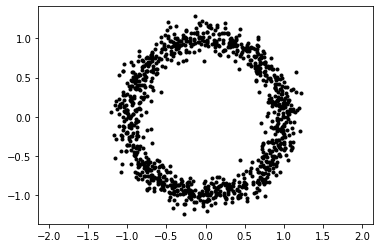

In [8]:
# Visualize data
data = sample_data_ring()
plt.plot(data[:,0],data[:,1],'k.')
plt.axis('equal');

In [9]:
# Sample from a target
def sample_data_target(r = 2, n = 1024, sigma = 0.2):
    n1 = np.ceil(n/2).astype(int)
    n2 = n-n1
    theta1 = np.random.uniform(low=0.0, high=2*np.pi, size=(n1,))
    theta2 = np.random.uniform(low=0.0, high=2*np.pi, size=(n2,))
    radius1 = np.random.randn(n1) * sigma + r
    radius2 = np.random.randn(n2) * 2*sigma 
    x1 = radius1*np.cos(theta1)
    y1 = radius1*np.sin(theta1)
    x2 = radius2*np.cos(theta2)
    y2 = radius2*np.sin(theta2)
    return np.concatenate((np.stack((x1,y1),axis = 1),np.stack((x2,y2),axis = 1)),axis=0)

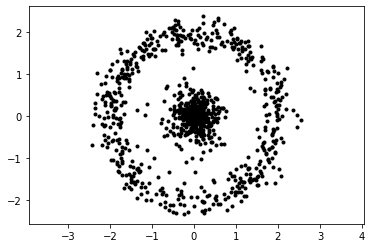

In [13]:
# Visualize data
data = sample_data_target()
plt.plot(data[:,0],data[:,1],'k.')
plt.axis('equal');

In [169]:
class Generator(nn.Module):
    def __init__(self, num_latents: int = 2, layers: list = [8,8], 
                act = nn.LeakyReLU, output_dimensions: int = 2, 
                norm_layer = nn.BatchNorm1d, bias=False):
        super().__init__()
        
        network = []
        network.append(nn.Linear(num_latents, layers[0], bias=bias))
        network.append(act())
        network.append(norm_layer(layers[0]))
        for i in range(1, len(layers)):
            network.append(nn.Linear(layers[i-1], layers[i], bias=bias))
            network.append(act())
            network.append(norm_layer(layers[i]))
        network.append(nn.Linear(layers[-1], output_dimensions))
        
        # print(network)
        self.network = nn.Sequential(*network)
        
    def forward(self, x):
        return(self.network(x))          
        

In [ ]:
# def generator( ... , reuse=False):
#     with tf.variable_scope("Generator",reuse=reuse):

#     return out

In [170]:
class Discriminator(nn.Module):
    def __init__(self, input_dim: int = 2, layers: list = [8,8], 
                act = nn.LeakyReLU, norm_layer = nn.BatchNorm1d, 
                bias = False):
        super().__init__()
        
        network = []
        network.append(nn.Linear(input_dim, layers[0], bias=bias))
        network.append(act())
        network.append(norm_layer(layers[0]))
        for i in range(1, len(layers)):
            network.append(nn.Linear(layers[i-1], layers[i], bias=bias))
            network.append(act())
            network.append(norm_layer(layers[i]))
        network.append(nn.Linear(layers[-1], 1))
        
        self.network = nn.Sequential(*network)
        
    def forward(self, x):
        return(self.network(x))

In [ ]:
# def discriminator( ... , reuse=False):
#     with tf.variable_scope("Discriminator",reuse=reuse):
       
#     return out

In [21]:
def sample_Z(shape: list = [2,1]):
    return(torch.randn(*shape))

In [ ]:
# def sample_Z( ... ):

#     return z

In [26]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [316]:
batch_size = 1024
epochs = 10000
k = 4
k2 = 1
lr = 0.001

num_latents = 3
generator_layers = [8,8,8]
discriminator_layers = [8,8,8]
sample_function = sample_data_target

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

generator = Generator(num_latents = num_latents,
                     layers = generator_layers, 
                     norm_layer = nn.BatchNorm1d).to(device)
discriminator = Discriminator(layers = discriminator_layers, 
                             norm_layer = nn.BatchNorm1d).to(device)

criterion = nn.BCEWithLogitsLoss(reduction='mean')

# params = list(generator.parameters()) + list(discriminator.parameters())

generator_opt = optim.Adam(generator.parameters(), lr=lr)
discriminator_opt = optim.Adam(discriminator.parameters(), lr=lr)
# optimizer = optim.Adam(params, lr=lr)

In [317]:
g_samples = []
r_samples = []
gloss_list = []
dloss_list = []
d_accuracy_list = []

for epoch in range(epochs):
    generator.eval()
    #     for param in generator.parameters():
    #         param.requires_grad = False

    discriminator.train()
    #     for param in discriminator.parameters():
    #         param.requires_grad = True
        
    #     optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    
    for i in range(k):
        discriminator_opt.zero_grad()
        
        z = sample_Z(shape=[batch_size//2, num_latents]).to(device)
        # z = torch.from_numpy(z).to(device)
        
        est = generator(z)
        x = sample_function(n = batch_size//2).astype(np.float32)
        x = torch.from_numpy(x).to(device)
        
        batch = torch.cat((est, x)).detach()
        targets = torch.cat((torch.zeros(batch_size//2, 1, requires_grad=False), 
                             torch.ones(batch_size//2, 1, requires_grad=False))).to(device)
        indices = torch.randperm(batch.shape[0])
        batch = batch[indices,...]
        targets = targets[indices]
        
        outputs = discriminator(batch)
        loss = criterion(outputs, targets)
        discriminator_loss = loss.item()
        dloss_list.append(discriminator_loss)
        
        
        loss.backward()
        discriminator_opt.step()
        
    generator.train()
    #     for param in generator.parameters():
    #         param.requires_grad = True
    discriminator.eval()
    #     for param in discriminator.parameters():
    #         param.requires_grad = False
    # optimizer = optim.Adam(generator.parameters(), lr=lr)
    
    for i in range(k2):
        generator_opt.zero_grad()
        
        z = sample_Z(shape=[batch_size, num_latents]).to(device)
        est = generator(z)
        batch = est
        targets = torch.ones(batch_size, 1, requires_grad=False).to(device)
        
        outputs = discriminator(batch)
        loss = criterion(outputs, targets)
        
        # generator 
        loss.backward()
        generator_opt.step()
        
        generator_loss = loss.item()
        gloss_list.append(generator_loss)
        
    if epoch % 100 == 0:
        print('D: {} G: {}'.format(discriminator_loss, generator_loss))

D: 0.6117500066757202 G: 0.5832692384719849
D: 0.5897554159164429 G: 0.9139125347137451
D: 0.6448384523391724 G: 0.89909827709198
D: 0.6245065331459045 G: 0.8249671459197998
D: 0.6355894804000854 G: 0.7868658304214478
D: 0.5388031005859375 G: 1.331487774848938
D: 0.6622605323791504 G: 0.7675646543502808
D: 0.66580730676651 G: 0.7425217032432556
D: 0.7013115882873535 G: 0.8019466996192932
D: 0.5528464317321777 G: 1.0228338241577148
D: 0.6407090425491333 G: 0.916479229927063
D: 0.6375755667686462 G: 0.7536829710006714
D: 0.6175239086151123 G: 0.9796991348266602
D: 0.6142418384552002 G: 1.002302885055542
D: 0.6726300716400146 G: 0.783908486366272
D: 0.6733787655830383 G: 0.7102603912353516
D: 0.6722716093063354 G: 0.7400387525558472
D: 0.6704484224319458 G: 0.7402438521385193
D: 0.680243968963623 G: 0.7080368995666504
D: 0.6821392774581909 G: 0.7354947328567505
D: 0.6761930584907532 G: 0.7158041000366211
D: 0.6607465744018555 G: 0.7371680736541748
D: 0.691710889339447 G: 0.738394856452941

KeyboardInterrupt: 

In [318]:
z = sample_Z(shape=[4096, num_latents]).to(device)
# z = torch.from_numpy(z).to(device)

fake_data = generator(z)
fake_data = fake_data.detach().cpu().numpy()
data = sample_function(n = 4096)

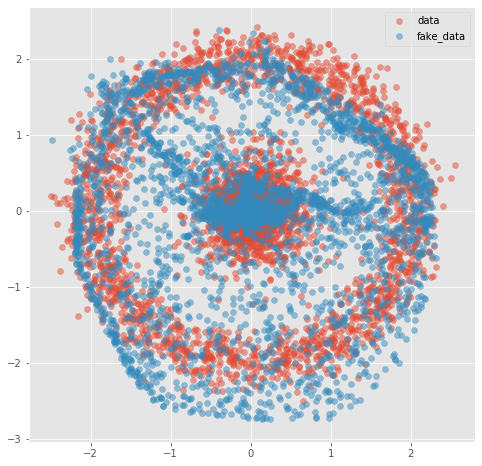

In [319]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(data[:,0], data[:,1], alpha=0.5, label='data')
ax.scatter(fake_data[:,0], fake_data[:,1], alpha=0.5, label='fake_data')
ax.legend()

plt.show()

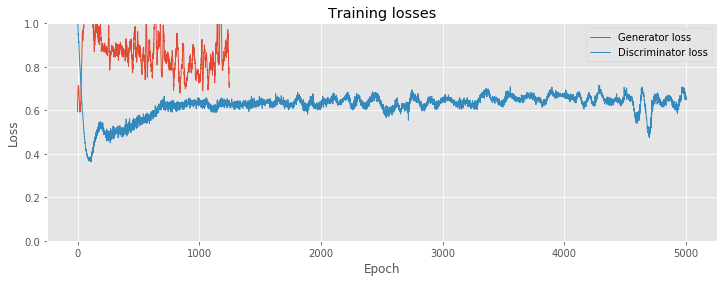

In [312]:
# Plot training losses
fig = plt.figure(figsize=(12,4))
plt.plot(gloss_list,linewidth = 1,label='Generator loss')
plt.plot(dloss_list,linewidth = 1,label='Discriminator loss')
plt.ylim([0,1])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training losses');

In [ ]:
# Plot generated data
plt.scatter(r_samples[-1][:,0],r_samples[-1][:,1], s = 0.5,c = 'r',label='Real data')
plt.scatter(g_samples[-1][:,0],g_samples[-1][:,1], s = 0.5,c = 'b',label='Generated data')
plt.xlim([-3.5,3.5])
plt.ylim([-3.5,3.5])
plt.axis('equal')
plt.legend(frameon=False)
plt.legend(bbox_to_anchor = (1.02,1), loc = 2, borderaxespad = 0.)
plt.title("G loss= %.4f\nD loss= %.4f, D acc= %.4f"%(dloss_list[-1],gloss_list[-1],d_accuracy_list[-1]));